# Multi-Armed Bandits, Conjugate Models and Bayesian Reinforcement Learning

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.special import expit
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('darkgrid')

/Users/george/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/george/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


Let's talk about Bayesianism. It's developed a reputation (not entirely
justified, but not entirely unjustified either) for being too mathematically
sophisticated or too computationally intensive to work at scale. For instance,
inferring from a Gaussian mixture model is fraught with computational problems
(hierarchical funnels, bimodal posteriors, etc.), and may take a seasoned
Bayesian anywhere between a day and a month to do well. On the other hand, other
blunt hammers of estimation are as easy as a maximum likelihood estimate:
something you could easily get a SQL query to do if you wanted to.

In this blog post I hope to show that there is more to Bayesianism than just
MCMC sampling and suffering, by demonstrating a Bayesian approach to a classic
reinforcement learning problem: the [_multi-armed bandit_](https://en.wikipedia.org/wiki/Multi-armed_bandit).

The problem is this: imagine a gambler at a row of slot machines (each machine
being a "one-armed bandit"), who must devise a strategy so as to maximize
rewards. This strategy includes which machines to play, how many times to play
each machine, in which order to play them, and whether to continue with the
current machine or try a different machine.

This problem is a central problem in probability and decision theory, and also
an instance of a _reinforcement learning_ problem: the agent (our gambler)
starts out in a state of ignorance, but learns through interacting with its
environment (playing slots). For more details, Cam Davidson Pilon has a great
introduction to multi-armed bandits in Chapter 6 of his book [_Bayesian Methods
for
Hackers_](https://nbviewer.jupyter.org/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter6_Priorities/Ch6_Priors_PyMC3.ipynb),
and Tor Lattimore and Csaba Szepesvári cover a breathtaking amount of the
underlying theory in their book [_Bandit
Algorithms_](http://banditalgs.com/).

So let's get started! I assume that you are familiar with:

- some basic probability, at least enough to know some distributions: normal,
  Bernoulli, binomial...
- some basic Bayesian statistics, at least enough to understand what a
  [conjugate prior](https://en.wikipedia.org/wiki/Conjugate_prior) (and
  conjugate model) is, and why one might like them.
- [Python generators and the `yield`
  keyword](https://jeffknupp.com/blog/2013/04/07/improve-your-python-yield-and-generators-explained/),
  to understand some of the code I've written.

Dive in!

## The Algorithm

The algorithm is straightforward. The description below is taken from [1].

For each round,
- Sample a random variable $X_b$ from the prior of bandit $b$, for all $b$
- Select the bandit with largest sample, i.e. select bandit $B = \text{argmax}(X_b)$
- Observe the result of pulling bandit $B$, and update your prior on bandit $B$
- Repeat

What I find remarkable about this is how dumbfoundingly simple it is! No MCMC sampling, no $\hat{R}$s to diagnose, no pesky divergences... all it requires is a conjugate model!

**NB:** This is known as _Thompson sampling_, and is only one of many algorithms out there. The main difference is that there are other ways to go from our current posteriors to a decision on which bandit to play next. E.g. instead of simply sampling from our posteriors, we could use the upper bound of the 90% credible region, or some dynamic quantile of the posterior (as in Bayes UCB). See [1] for more information.

## (Stationary) Stochastic Bandits

Assume we have rewards which are Bernoulli distributed. This would be the situation we face when e.g. predicting click-through rates.

In [2]:
def make_bandits(params):
    def pull(arm, size=None):
        while True:
            # Bernoulli distributed rewards
            reward = np.random.binomial(n=1, p=params[arm], size=size)
            yield reward
    
    return pull, len(params)


def bayesian_strategy(pull, num_bandits):
    num_rewards = np.zeros(num_bandits)
    num_trials = np.zeros(num_bandits)
    
    while True:
        # Sample from the bandits' priors, and choose largest
        choice = np.argmax(np.random.beta(a=2+num_rewards,
                                          b=2+num_trials-num_rewards))
        
        # Sample the chosen bandit
        reward = next(pull(choice))
        
        # Update
        num_rewards[choice] += reward
        num_trials[choice] += 1
        
        yield choice, reward, num_rewards, num_trials

In [3]:
def plot_posteriors(num_rewards, num_trials, n, ax):
    ''' Helper function to plot posteriors '''
    x = np.linspace(0, 1, 100)
    for i in range(num_bandits):
        line = stats.beta.pdf(x, 2+num_rewards[i], 2+num_trials[i]-num_rewards[i])
        ax.plot(x, line)
        ax.fill_between(x, 0, line, alpha=0.3)
    title = 'Posterior after {} pulls'.format(n) if n > 1 else 'Posterior after 1 pull'
    ax.set_title(title)

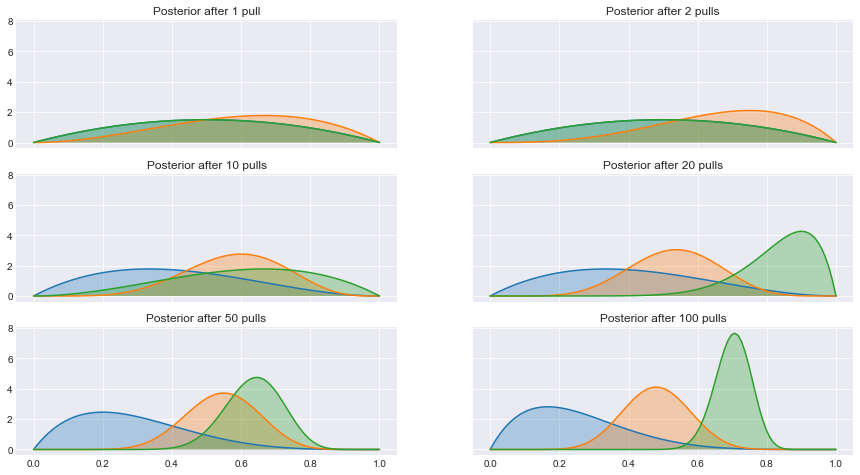

In [4]:
pull, num_bandits = make_bandits([0.2, 0.5, 0.7])
play = bayesian_strategy(pull, num_bandits)

fig, axarr = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True, figsize=[15, 8])
pulls_to_plot = [1, 2, 10, 20, 50, 100]
ax_idx = 0

for i in range(1, max(pulls_to_plot)+1):
    choice, reward, num_rewards, num_trials = next(play)
    
    if i in pulls_to_plot:
        plot_posteriors(num_rewards, num_trials, i, axarr.flatten()[ax_idx])
        ax_idx += 1

## Generalizing to Conjugate Models

This will work for any [conjugate model](https://en.wikipedia.org/wiki/Conjugate_prior#Table_of_conjugate_distributions)! Here I implement the Gamma-Poisson model to illustrate how extensible this framework is.

To change:

- The rewards distribution (in practice, you don't get to pick this, so _technically_ nothing to change if you're doing this in production!)
- The sampling from the prior
- The update rule

This really highlights the elegance and simplicity of conjugate models! They're not just textbook examples: they're actually useful!

In [5]:
def make_bandits(params):
    def pull(arm, size=None):
        while True:
            # Poisson distributed rewards
            reward = np.random.poisson(lam=params[arm], size=size)
            yield reward
    
    return pull, len(params)


def bayesian_strategy(pull, num_bandits):
    num_rewards = np.ones(num_bandits)
    num_trials = np.ones(num_bandits)
    
    while True:
        # Sample from the bandits' priors, and choose largest
        choice = np.argmax(np.random.gamma(num_rewards,
                                           scale=1/num_trials))
        
        # Sample the chosen bandit
        reward = next(pull(choice))
        
        # Update
        num_rewards[choice] += reward
        num_trials[choice] += 1
        
        yield choice, reward, num_rewards, num_trials

In [6]:
def plot_posteriors(num_rewards, num_trials, n, ax):
    ''' Helper function to plot posteriors '''
    x = np.linspace(0, 10, 100)

    for i in range(num_bandits):
        line = stats.gamma.pdf(x, a=num_rewards[i], scale=1/num_trials[i])
        ax.plot(x, line)
        ax.fill_between(x, 0, line, alpha=0.3)
    
    title = 'Posterior after {} pulls'.format(n) if n > 1 else 'Posterior after 1 pull'
    ax.set_title(title)

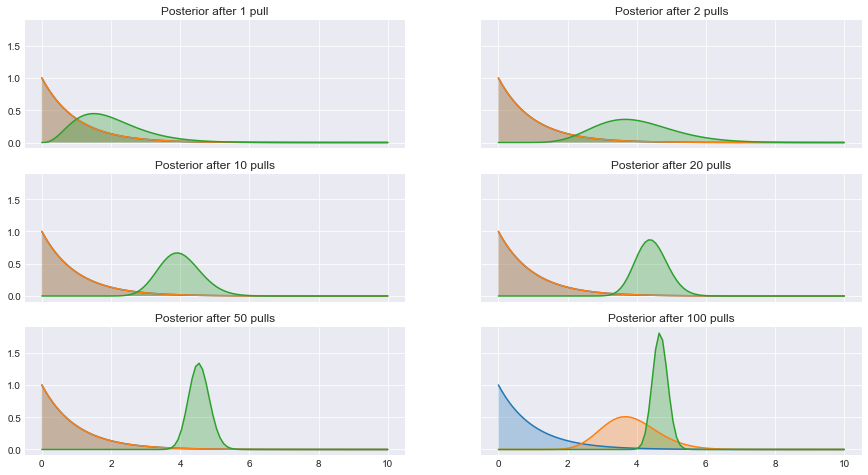

In [7]:
pull, num_bandits = make_bandits([4, 4.5, 5])
play = bayesian_strategy(pull, num_bandits)

fig, axarr = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True, figsize=[15, 8])
pulls_to_plot = [1, 2, 10, 20, 50, 100]
ax_idx = 0

for i in range(1, max(pulls_to_plot)+1):
    choice, reward, num_rewards, num_trials = next(play)
    
    if i in pulls_to_plot:
        plot_posteriors(num_rewards, num_trials, i, axarr.flatten()[ax_idx])
        ax_idx += 1

## Generalizing to Arbitrary Rewards Distributions

In general very difficult to do quickly. Theoretically we can run MCMC to get our posterior, but that doesn't scale, especially for the online algorithms that we have in mind. Luckily [2] gives us some help, _if we assume rewards are bounded_. It bootstraps the Beta-Bernoulli model above.

1. Sample from (Beta) priors
2. Select $B$, bandit with largest sample
3. Observe the reward $R$ from bandit $B$
4. **Observe the outcome $r$ from a Bernoulli trial with probability of success $R$**
5. Update posterior of $B$ with this observation $r$
6. Repeat

Here I do this for the logit-normal distribution (i.e. a random variable whose logit is normally distributed).

In [8]:
def make_bandits(params):
    def pull(arm, size=None):
        while True:
            # Logit-normal distributed returns (or any distribution with finite support)
            # `expit` is the inverse of `logit`
            reward = expit(np.random.normal(loc=params[arm], scale=1, size=size))
            yield reward
    
    return pull, len(params)


def bayesian_strategy(pull, num_bandits):
    num_rewards = np.zeros(num_bandits)
    num_trials = np.zeros(num_bandits)
    
    while True:
        # Sample from the bandits' priors, and choose largest
        choice = np.argmax(np.random.beta(2+num_rewards,
                                          2+num_trials-num_rewards))
        
        # Sample the chosen bandit
        reward = next(pull(choice))
        
        # Sample a Bernoulli with probability of success = reward
        # Remember, reward is normalized to be in [0, 1]
        outcome = np.random.binomial(n=1, p=reward)
        
        # Update
        num_rewards[choice] += outcome
        num_trials[choice] += 1
        
        yield choice, reward, num_rewards, num_trials

In [9]:
def plot_posteriors(num_rewards, num_trials, n, ax):
    ''' Helper function to plot posteriors '''
    x = np.linspace(0, 1, 100)

    for i in range(num_bandits):
        line = stats.beta.pdf(x, 2+num_rewards[i], 2+num_trials[i]-num_rewards[i])
        ax.plot(x, line)
        ax.fill_between(x, 0, line, alpha=0.3)
    
    title = 'Posterior after {} pulls'.format(n) if n > 1 else 'Posterior after 1 pull'
    ax.set_title(title)

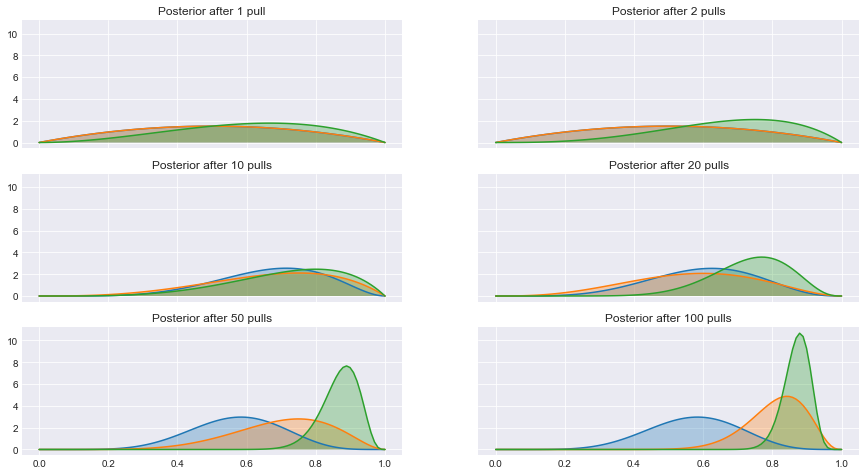

In [10]:
pull, num_bandits = make_bandits([0.2, 1.8, 2])
play = bayesian_strategy(pull, num_bandits)

fig, axarr = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True, figsize=[15, 8])
pulls_to_plot = [1, 2, 10, 20, 50, 100]
ax_idx = 0

for i in range(1, max(pulls_to_plot)+1):
    choice, reward, num_rewards, num_trials = next(play)
    
    if i in pulls_to_plot:
        plot_posteriors(num_rewards, num_trials, i, axarr.flatten()[ax_idx])
        ax_idx += 1

## References

[1] https://dataorigami.net/blogs/napkin-folding/79031811-multi-armed-bandits

[2] http://proceedings.mlr.press/v23/agrawal12/agrawal12.pdf

## Environment

In [11]:
!conda list --explicit

# This file may be used to create an environment using:
# $ conda create --name <env> --file <this file>
# platform: osx-64
@EXPLICIT
https://repo.anaconda.com/pkgs/main/osx-64/blas-1.0-mkl.tar.bz2
https://repo.anaconda.com/pkgs/main/osx-64/ca-certificates-2018.03.07-0.tar.bz2
https://repo.anaconda.com/pkgs/main/osx-64/compiler-rt-4.0.1-h5487866_0.tar.bz2
https://repo.anaconda.com/pkgs/main/osx-64/intel-openmp-2018.0.3-0.tar.bz2
https://repo.anaconda.com/pkgs/main/osx-64/libcxxabi-4.0.1-hebd6815_0.tar.bz2
https://repo.anaconda.com/pkgs/main/osx-64/libgfortran-3.0.1-h93005f0_2.tar.bz2
https://repo.anaconda.com/pkgs/main/osx-64/tk-8.6.7-h35a86e2_3.tar.bz2
https://repo.anaconda.com/pkgs/main/osx-64/xz-5.2.4-h1de35cc_4.tar.bz2
https://repo.anaconda.com/pkgs/main/osx-64/zlib-1.2.11-hf3cbc9b_2.tar.bz2
https://repo.anaconda.com/pkgs/main/osx-64/libcxx-4.0.1-h579ed51_0.tar.bz2
https://repo.anaconda.com/pkgs/main/osx-64/libpng-1.6.34-he12f830_0.tar.bz2
https://repo.anaconda.com/pkgs/main/osx-64